## Intro

Forecasting is an important task of time series analysis because it allows a data scientist to identify patterns by using machine learning and then generate forecasts about the future. Deep learning for forecasting is an exciting topic in data science that is beginning to show promise when compared to benchmarks from more traditional statistical methods such as [ARIMA](https://ibm.com/topics/arima-model.html). Foundation models for time series data are similar to other forms of generativeAI that are trained on large-scale time series datasets and can output either deterministic or probabilistic forecasts.

Recently, it's been shown that large language models (LLMs) don't perform especially well in time series forecasting tasks. The authors of [Are Language Models Actually Useful for Time Series Forecasting?](https://arxiv.org/pdf/2406.16964) tested OneFitsAll and LLaTA (both based on GPT-2 models), and Time-LLM (based on LLaMA), and found that, in their words, "popular methods for adapting language models for time series forecasting perform the same or worse than basic ablations, yet require orders of magnitude more compute." But LLMs aren't the only types of [foundation models]( https://research.ibm.com/blog/what-are-foundation-models). Foundation models have been built for time series forecasts such as [Moirai](https://github.com/redoules/moirai), [TimeGPT-1](https://arxiv.org/abs/2310.03589) and [TimesFM](https://research.google/blog/a-decoder-only-foundation-model-for-time-series-forecasting/).

[TinyTimeMixer (TTM)](https://arxiv.org/pdf/2401.03955) is another compact foundation time-series model for forecasting, open-sourced by IBM Research®. With fewer than 1 million parameters, TTM introduces the notion of “tiny” pretrained models for time-series forecasting. Unlike LLM-based forecasting models, TTM is a fast and compact model (starting from 1 million parameters) with effective transfer learning capabilities, trained exclusively on public TS datasets. TTM, based on the lightweight TSMixer architecture, incorporates innovations such as adaptive patching, diverse resolution sampling and resolution prefix tuning to handle pretraining on varied dataset resolutions with minimal model capacity.

TinyTimeMixer doesn't use self-attention heads such as a [transformer model]( https://www.ibm.com/topics/transformer-model). Instead, it uses what's called [gated attention](https://arxiv.org/abs/1912.00349) to control simpler blocks of perceptrons that correlate multiple variables in a time series. The goal of this architecture is to keep the model from overcomplicating what it pays attention to and to make training and fine-tuning less computationally expensive. The version of TTM we'll use in this tutorial is pretrained using a 1 billion parameter pretraining dataset that can be pre-trained in only 24–30 hours. This scenario is notably faster than transformer-basedapproaches that often take days to weeks to train.

In this tutorial, we'll use the TTM model and the IBM Time Series Foundation Models Python libraries to test how TTM does in two different forecasting tasks. Zero-shot learning is when the model is not trained on the data it’s trying to predict. It’s an interesting test of how well our model can detect and respond to the patterns present in the time series. After that, we’ll fine tune the model to see whether there’s a performance boost. Let's get started.

## Step 1: Set up your environment

In this step, we’ll guide you through creating an IBM account to access Jupyter Notebooks.

1. Log in to watsonx.ai™ using your IBM® Cloud® account.

2. Click + to create a new project.

* Select Create an empty project.
* Enter a project name in the Name field.
* Create a Cloud Object Storage for storing your project assets if not already created.
* Select Create.

3. Create a Jupyter Notebook.

* Select the Assets tab in your project environment.
* Click New asset.
* Select the Working with models option in the left panel.
* Click Working with data and models using Python and R notebooks.
* Enter a name for your notebook in the Name field. Choose Runtime 23.1 on Python (2 vCPU 8 GB RAM) to define the configuration.
* Select Create.

3. (Alternative) Upload a Jupyter Notebook.

* Select the Assets tab in your project environment.
* Click New asset.
* Select the Working with models option in the left panel.
* Click Working with data and models using Python and R notebooks.
* Click Local File in the left-hand tab
* Download the notebook from [Github]( https://github.com/joshuajnoble/TTM_tutorial)
* Enter a name for your notebook in the Name field. Choose Runtime 23.1 on Python (2 vCPU 8 GB RAM) to define the configuration.
* Select Create.

## Step 2 Clone the TSFM repository and install libraries

To use the TTM model, we'll clone the open source IBM Time Series Foundation Model (TSFM) library from the Github repository and install it on the watsonx.ai instance.

In [ ]:
# Clone the ibm and tsfm

! git clone https://github.com/IBM/tsfm.git

# Change directory. Move inside the tsfm repo.

%cd tsfm

# Install the tsfm library and scikit-learn

! pip install ".[notebooks]" scikit-learn

%cd ../

Cloning into 'tsfm'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 130 (delta 16), reused 52 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (130/130), 8.27 MiB | 18.30 MiB/s, done.
Resolving deltas: 100% (16/16), done.
Note: switching to 'f856e5bfc739dc23b2a2dace13bbe3b45d21ceee'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false



## Step 3: Import libraries

TSFM relies on several Hugging Face libraries that we'll use to load our models, fine-tune them and get forecasts.

In [5]:
# Standard
import os
import math
import tempfile
import torch

# Third Party
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
import numpy as np
import pandas as pd

# Local
from tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction
from tsfm_public.toolkit.callbacks import TrackingCallback

## Step 4: Load data

We'll use the [Beijing Air Quality dataset](https://archive.ics.uci.edu/dataset/381/beijing+pm2+5+data). This hourly data set contains the multivariate time series data of the PM2.5 data of US Embassy in Beijing. It also includes meteorological data from the Beijing Capital International Airport that we can use as exogenous variables for our forecasts.Our goal is to forecast PM2.5, stored in our `target_column`, using past values of the data and exogenous variables, stored in the `observable_columns`.


In [ ]:
from tsfm_public import (
    TimeSeriesPreprocessor,
    TinyTimeMixerForPrediction,
    TrackingCallback,
    count_parameters,
    get_datasets,
)

timestamp_column = "date"
target_columns = ["pm2.5"]
observable_columns = ["DEWP","TEMP","PRES","Iws"]

pollution_data = pd.read_csv(
    "https://archive.ics.uci.edu/static/public/381/beijing+pm2+5+data.zip"
)

pollution_data['date'] = pd.to_datetime(pollution_data[['year','month','day', 'hour']])


Data lengths: train = 34452, val = 4288, test = 4287


Because there are sensor errors leading to NaN (not a number) values in the time series, we'll interpolate the values to fill in any missing values.

#deal with NA
pollution_data['pm2.5'] = pollution_data['pm2.5'].interpolate()
pollution_data['cbwd'] = pollution_data['cbwd'].astype('category').cat.codes

data_length = len(pollution_data)

## Step 5: Prepare data

Next, we prepare our data to do zero-shot prediction and then fine-tuning.

In [6]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# Results dir
OUT_DIR = "ttm_finetuned_models/"

# TTM model branch
# Use main for 512-96 model
# Use "1024_96_v1" for 1024-96 model
TTM_MODEL_REVISION = "main"

# Forecasting parameters
context_length = 512
forecast_length = 96
fewshot_fraction = 0.05

Now we configure the train, evaluation and testing splits in the dataset. We'll use 80% of the data for training, 10% for evaluation and a further 10% for testing. This data is stored in the dictionary object that we use later.

In [ ]:
train_start_index = 0
train_end_index = round(data_length * 0.8)

eval_start_index = round(data_length * 0.8)
eval_end_index = round(data_length * 0.9)

test_start_index = round(data_length * 0.9)
test_end_index = data_length

split_config = {
                "train": [0, train_end_index],
                "valid": [eval_start_index, eval_end_index],
                "test": [test_start_index,test_end_index],
            }


Finally, we specify which columns we'll use and configure a `TimeSeriesPreprocessor` instance to scale our values to a normalized scale. Once we've configured the TimeSeriesPreprocessor, we use it to generate train, validation and test_datasets with the `get_datasets`method. This method uses the split configuration to create torch vectors from our dataset that can be used for training and evaluation. It also configures the TimeSeriesPreprocessor to properly scale the data down to normalized values that are easier for our model to interpret and predict.


In [ ]:
#our observable columns are the covariates for our target column
column_specifiers = {
    "timestamp_column": timestamp_column,
    "target_columns": target_columns,
    "observable_columns": observable_columns
}

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=True,
    encode_categorical=True,
    scaler_type="standard",
)

# this gets torch vectors, training wants those. For test eval we need a Pandas DF
train_dataset, valid_dataset, test_dataset = get_datasets(
    tsp, pollution_data, split_config
)
print(f"Data lengths: train = {len(train_dataset)}, val = {len(valid_dataset)}, test = {len(test_dataset)}")

Now we have torch datasets ready to use in testing and training.

## Step 6: Load TTM and evaluate

Let's see how the pretrained TTM model does with zero-shot forecasting. We load the model by using `TinyTimeMixerForPrediction.from_pretrained()`and then configure a HuggingFace Trainer to evaluate the `test` portion of the pollution dataset by calling `evaluate()`

In [8]:
import inspect
from tsfm_public import ForecastDFDataset

#inspect.getmembers(ForecastDFDataset, predicate=inspect.isfunction)

print(train_dataset.__getitem__(len(train_dataset) - 1)['timestamp'])
print(valid_dataset.__getitem__(0)['timestamp'])

print(valid_dataset.__getitem__(len(valid_dataset) - 1)['timestamp'])
print(test_dataset.__getitem__(0)['timestamp'])

2013-12-27 18:00:00
2013-12-31 18:00:00
2014-06-28 09:00:00
2014-07-02 09:00:00



When we look at the PM2.5 and windspeed, we can see that it's going to be a difficult time series dataset to work with because of the significant changes between data points and time points.

<Axes: xlabel='date'>

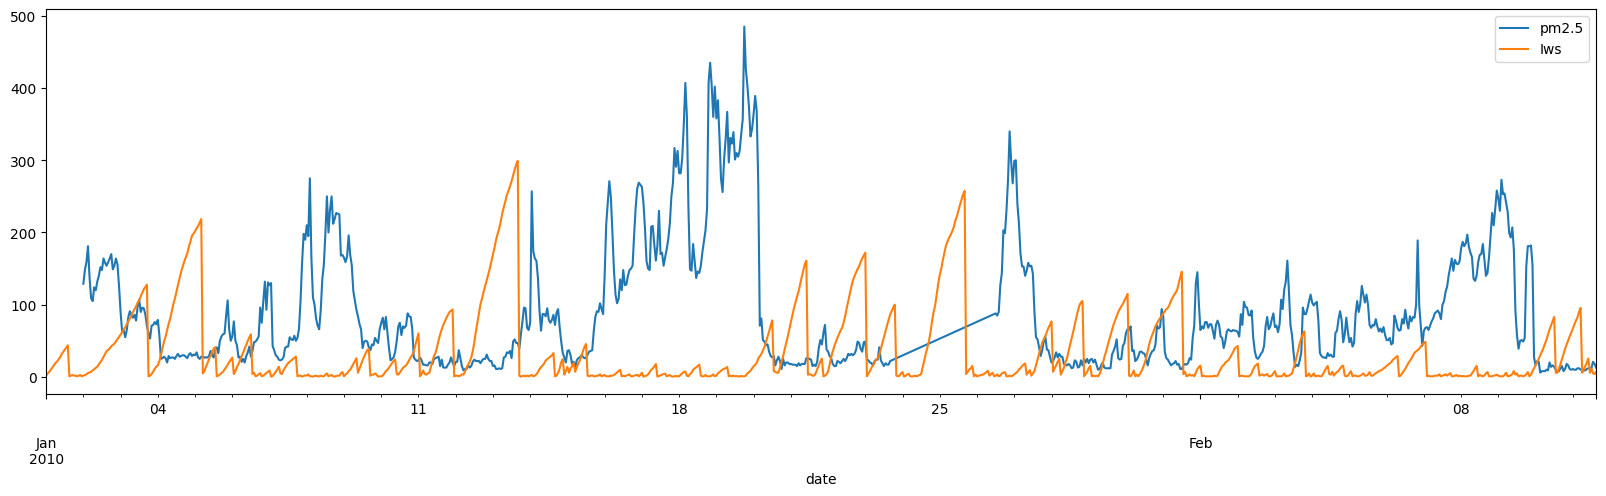

In [9]:
pollution_data[:1000].plot(x="date", y=["pm2.5", "Iws"], figsize=(20,5))

Let's see how the pretrained TTM model does with zero-shot forecasting. We load the model by using `TinyTimeMixerForPrediction.from_pretrained()`and then configure a HuggingFace Trainer to evaluate the `test` portion of the pollution dataset by calling `evaluate()`

In [ ]:
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained("ibm/TTM", revision="main", prediction_filter_length=24)

# zeroshot_trainer
zeroshot_trainer = Trainer(
    model=zeroshot_model,
)

zeroshot_trainer.evaluate(test_dataset)


This example returns the mean absolute error (MAE):

```
{'eval_loss': 0.324662446975708,
 'eval_model_preparation_time': 0.0046,
 'eval_runtime': 11.4272,
 'eval_samples_per_second': 375.157,
 'eval_steps_per_second': 46.906}
```

The result shows us that the `eval_loss` is approximately 0.426. We'll compare this result to the fine-tuned value in step 9.

## Step 7: Use TTM for forecasting

To use our TTM model for forecasting, we need to create a TimeSeriesForecastingPipeline object that will pass data to our model and generate predictions. We have our TimeSeriesPreprocessor preprocess the data before we pass it to the TimeSeriesForecastingPipeline. If you were building a production system that read in real-world data and created predictions from it, you would create a TimeSeriesForecastingPipeline object and pass new data to that to generate forecasts. In this tutorial, for testing purposes, we're just passing the entire test dataset to generate predictions for each timestamp in the dataset.


In [11]:
from tsfm_public.toolkit.util import select_by_index
from tsfm_public.toolkit.time_series_forecasting_pipeline import TimeSeriesForecastingPipeline
from tsfm_public.toolkit.visualization import plot_ts_forecasting

test_data = tsp.preprocess(pollution_data[test_start_index:test_end_index])

zs_forecast_pipeline = TimeSeriesForecastingPipeline(
    model=zeroshot_model,
    device="cpu",
    timestamp_column=timestamp_column,
    id_columns=[],
    target_columns=target_columns,
    freq="1h"
)

Now it's time to pass our test data and get results. Note that the TimeSeriesForecastingPipeline takes a Pandas DataFrame. This method is different from the `evaluate()` method of the trainer, which takes a torch array.


In [12]:
zs_forecast = zs_forecast_pipeline(test_data)

When we look at the returned forecast objects, it's important to note that there are 24 of them in the `pm2.5_predictions` field. This forecast is because we asked the model to return a window with 24 timestamps worth of predictions for each prediction. To compare the predictions to the actual values, then we can simply plot the predictions and the actual values:

<Axes: >

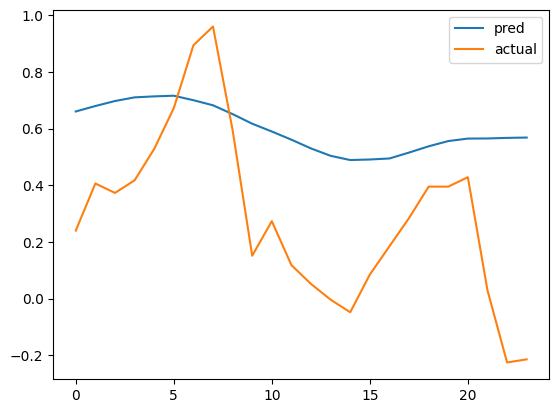

In [32]:
spot_check_index = 200

#fcast_df = pd.DataFrame({"pred":zs_forecast.loc[spot_check_index]['pm2.5_prediction'], "actual":zs_forecast.loc[spot_check_index]['pm2.5'][:24]})
fcast_df = pd.DataFrame({"pred":zs_forecast.loc[spot_check_index]['pm2.5_prediction'], "actual":zs_forecast.loc[spot_check_index]['pm2.5'][:24]})
fcast_df.plot()

## Step 8: Evaluating forecast results

To evaluate our forecast results, we 'll see how they do against the actual PM2.5 readings 12 hours later.


In [13]:
def compare_forecast(forecast, date_col, prediction_col, actual_col, hours_out):
  comparisons = pd.DataFrame()
  comparisons[date_col] = forecast[date_col]
  actual = []
  pred = []

  for i in range(len(forecast)):
    pred.append(forecast[prediction_col].values[i][hours_out - 1]) # prediction for next day
    actual.append(forecast[actual_col].values[i][hours_out - 1])

  comparisons['actual'] = actual
  comparisons['pred'] = pred

  return comparisons

Now we can use this method to compare our forecasted PM2.5 values to the actual PM2.5 values. We pass the forecast and actual dataframes, the fields that we'll need to compare, and the time offset for our predictions. We might use mean absolute error (MAE) or mean absolute percentage error (MAPE) but in our case, with so many very small or negative values the root mean squared error (RMSE) will work well.

We get an RMSE of ~0.844.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


<Axes: title={'center': '0.8438783084'}, xlabel='date'>

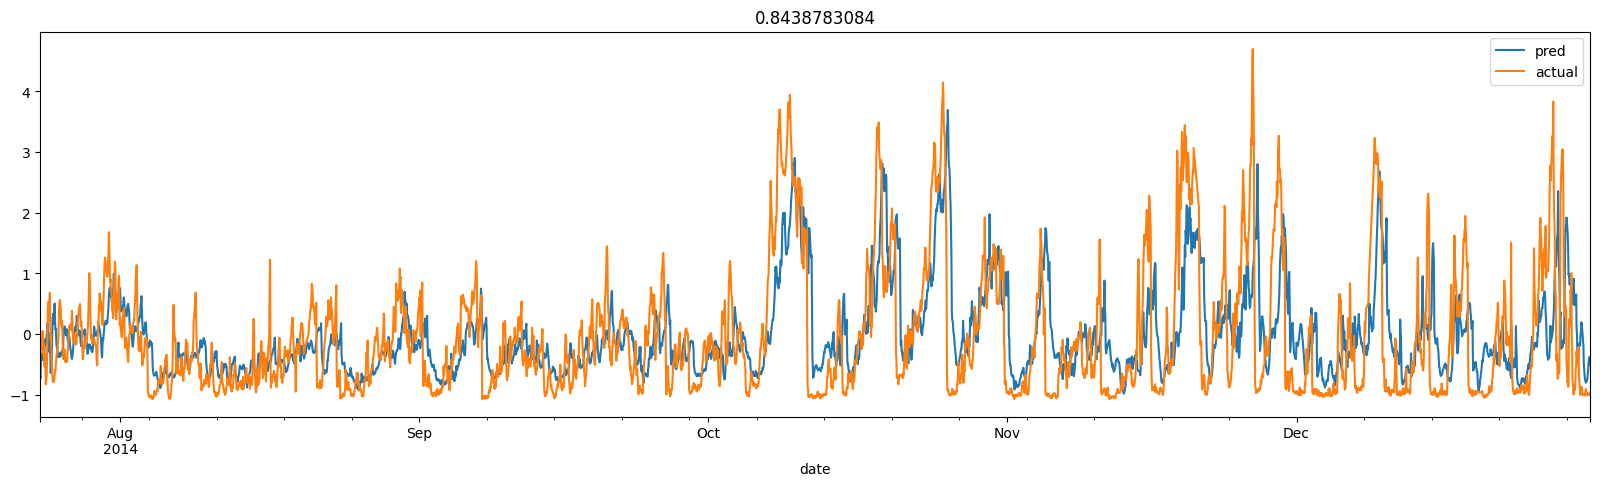

In [16]:
from sklearn.metrics import mean_squared_error

one_day_out_predictions = compare_forecast(zs_forecast, "date", "pm2.5_prediction", "pm2.5", 12)

out = one_day_out_predictions[[not np.isnan(x).any() for x in one_day_out_predictions['actual']]]

rms = '{:.10f}'.format(mean_squared_error(out['actual'], out['pred'], squared=False))
out.plot(x="date", y=["pred", "actual"], figsize=(20,5), title=str(rms))


We can see how the zero-shot model doesn't predict the spikes in PM2.5 and overcorrects to account for them.

## Step 9: Fine tuning TTM

Now let's fine-tune the model weights of a version of TTM with our training data and then evaluate it on the test set. First, we need to configure the TrainingArguments. This is a long function call but boils down to simply configuring the learning rate, the number of epochs to train for, the batch size and the early stopping.

In [17]:
finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm/TTM", revision=TTM_MODEL_REVISION, prediction_filter_length=24
)

In [18]:
# Freeze the backbone of the model
for param in finetune_forecast_model.backbone.parameters():
    param.requires_grad = False

In [ ]:
# Important parameters
learning_rate = 0.0001
num_epochs = 20
batch_size = 16

finetune_forecast_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    do_eval=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=8,
    report_to=None,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    logging_dir=os.path.join(OUT_DIR, "logs"),  # Make sure to specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
)

Because our model might overfit, we create an early stopping function. This is also where we configure the scheduler and optimizer that the Trainer will use.

In [ ]:
# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=2,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.01,  # Minimum improvement required to consider as improvement
)
tracking_callback = TrackingCallback()

# Optimizer and scheduler
optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(
    optimizer,
    learning_rate,
    epochs=num_epochs,
    steps_per_epoch=math.ceil(len(train_dataset) / (batch_size)),
)

Once we have all our training parameters configured, we can begin fine-tuning our model. We pass all the configuration parameters to the trainer along with the model that we want to fine-tune and the train and evaluation datasets that we configured earlier. When possible, we want to use early stopping to keep our training process from overfitting our training data. The call to `train()` starts the process off. You'll notice that TTM fine-tunes very quickly, in about 15 minutes just on the CPU and much faster if you use a GPU.

In [ ]:

finetune_forecast_trainer = Trainer(
    model=finetune_forecast_model,
    args=finetune_forecast_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback, tracking_callback],
    optimizers=(optimizer, scheduler),
)

# Fine tune
finetune_forecast_trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.343000,0.271360
2,0.317000,0.262891
3,0.303600,0.259591


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[TrackingCallback] Mean Epoch Time = 55.34480015436808 seconds, Total Train Time = 178.8160560131073


TrainOutput(global_step=6462, training_loss=0.3211893774119371, metrics={'train_runtime': 178.8294, 'train_samples_per_second': 3853.058, 'train_steps_per_second': 240.9, 'total_flos': 1278420782284800.0, 'train_loss': 0.3211893774119371, 'epoch': 3.0})

Now we have a fine-tuned model that we can evaluate.

## Step 10: Evaluating the fine-tuned TTM

We'll evaluate the fine-tuned TTM in the same way as the zeroshot version of the model. Our first step will be to use the `evaluate()` method of the trainer instance:

In [20]:
finetune_forecast_trainer.evaluate(test_dataset)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'eval_loss': 0.2680470645427704,
 'eval_runtime': 3.6021,
 'eval_samples_per_second': 1190.155,
 'eval_steps_per_second': 74.402,
 'epoch': 3.0}

We can see that the `eval_loss` is 0.268 or 0.172 better than the model that was not fine-tuned. This is a small improvement but a significant one.

Now create a ForecastingPipeline to use the finetuned model and the exogenous variables by passing the `observable_columns` to the pipeline.


In [ ]:
test_data = tsp.preprocess(pollution_data[test_start_index:test_end_index])

forecast_pipeline = TimeSeriesForecastingPipeline(
    model=finetune_forecast_model,
    device="cpu",
    timestamp_column=timestamp_column,
    id_columns=[],
    target_columns=target_columns,
    observable_columns=observable_columns,
    freq="1h"
)
context_length = finetune_forecast_model.config.context_length

forecasts = forecast_pipeline(test_data)

A spot check on the forecasting from the finetuned model shows that it does a better job of capturing the downward trend of the PM2.5 data:

<Axes: >

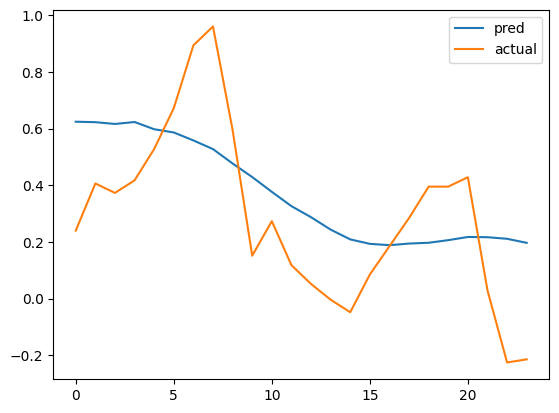

In [ ]:


fcast_df = pd.DataFrame({"pred":forecasts.loc[spot_check_index]['pm2.5_prediction'], "actual":forecasts.loc[spot_check_index]['pm2.5'][:24]})
fcast_df.plot()

Let's see how our model does on forecasting 12 hours out:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


<Axes: title={'center': 'RMSE:0.8002724378'}, xlabel='date'>

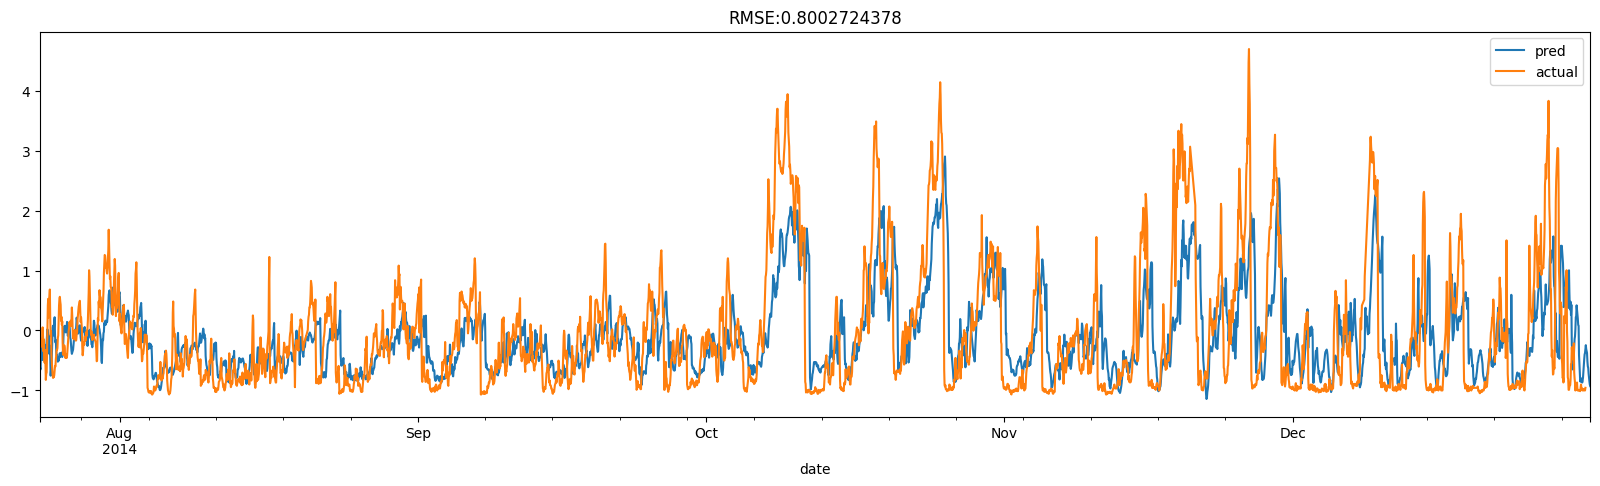

In [25]:
one_day_out_predictions = compare_forecast(forecasts, "date", "pm2.5_prediction", "pm2.5", 12)

out = one_day_out_predictions[[not np.isnan(x).any() for x in one_day_out_predictions['actual']]]

rms = '{:.10f}'.format(mean_squared_error(out['actual'], out['pred'], squared=False))
one_day_out_predictions.plot(x="date", y=["pred", "actual"], figsize=(20,5), title="RMSE:" + str(rms))


The RMSE is here: 0.800 so we can see that our fine-tuning has given us some improvement on a very difficult dataset. The forecast corrects much more quickly than the zero-shot version because it has access to the training data and the covariate exogenous variables.

## Conclusion

In this tutorial you learned about foundation models for forecasting, an area of research in artificial intelligence with important applications in healthcare, environmental monitoring, anomaly detection and many other fields and tasks. You used the IBM Granite TinyTimeMixer model, a foundation model trained on time series data specifically built for forecasting. You used the base model to perform zero-shot forecasting on an air pollution dataset. You then fine-tuned the TTM data with training data from the air pollution dataset. You then generated forecasts from that fine-tuned model and compared its performance to the zero-shot dataset.

You can learn more about the Granite Time Series Models at their Hugging Face site [here](https://huggingface.co/collections/ibm-granite/granite-time-series-models-663a90c6a2da73482bce3dc6).

Build an [artificial intelligence](https://www.ibm.com/consulting/artificial-intelligence) (AI) strategy for your business on one collaborative AI and data platform called [IBM watsonx](https://www.ibm.com/watsonx), which combines new generative AI capabilities powered by foundation models and traditional machine learning into a powerful platform spanning the AI lifecycle. With watsonx.ai, you can train, validate, tune and deploy models with ease and build AI applications in a fraction of the time with a fraction of the data.

Try watsonx.ai, the next-generation studio for AI builders. Explore more articles and tutorials about watsonx on IBM Developer.
